##  **Résumé :** 




L'objet de ce projet informatique est la colorisation d'une image, initialement en noire et blanc, à l'aide d'un algorithme entrainé par apprentissage supervisé. Le but final est, étant donnée une page de manga (*note* : les pages de mangas sont presque toujours en noir et blanc), d'obtenir la colorisation la plus fidèle possible.

Initialement, les images sont représentées à l'aide du format RGB. Chaque image est donc un array de taille (n,n,3) où n représente la hauteur/largeur de l'image (on prendra n = 256). Chaque image est donc composé de trois couches d'array 256x256 : un couche pour le bleu, une couche pour le rouge, et une couche pour le vert. Ce format n'est pas très adapté pour notre travail puisqu'il ne contient pas de couche représentant le noir et blanc (qui sera notre *input*) et qu'ils contient trois couches de couleurs, ce qui signifie qu'il faudrait travailler sur les trois couches.
Pour remedier à ce problème, on va travailler sur le format LAB : les images sont toujours des array de taille (n,n,3), mais cette fois il y a une couche de *grayscale* (image en noir et blanc) et deux couches de couleurs correspondant aux spectre des couleurs du vert-rouge et du bleu jaune. Préalablement, nous allons également normaliser les matrices pour que tous leurs coefficients soient tous compris entre -1 et 1 (pour des raisons de précisions); nous les dé-normaliserons à la sortie de l'algorithme. Le format LAB est plus adapté aux *input* et *outputs* de notre programme : il prend en entrée la première couche de l'image (*grayscale*) et renvoie les deux dernières couches (images colorées). Pour avoir l'image finale, il suffit de concatener ces trois couches.

Nous utilisons un data set composé d'environ 10 000 images, issues du site internet *kaggle* en les mettant dans un drive partagé.

Pour arriver à notre but, nous mettons en place un réseau de neuronne convolutif en 2D (pour travailler sur les matrices) composé de 15 couches de neurones : 3 couches de neurones de type *UpSampling* (entre haut pour *smoother* l'image), et 12 couches de neurones de type convolution.
Nous estimons la précision de notre algorithme à l'aide de la MSE (mean square error). 

Il apparait que nous avons une fonction de perte assez faible, mais que le résultat obtenu n'est pas satisfaisant. En effet, l'output ressemble à une version "marron" de l'image en noire et blanc. Cela provient du fait que le marron est la couleur la plus "proche" de tous les autres couleurs (en terme de RGB). Il semble que ce soit un problème récurrent à la colorisation d'images. Voici quelques pistes d'hypothèses :


*   Problème au niveau du dataset : cela ne semble pas être un problème de quantité puisque empiriquement, nous avons constaté que le nombre d'image a peu voire pas d'impact; cela ne semble pas être un problème de qualité non plus puisque les utilisateurs du dataset semblent en être satisfait
*   Durée de l'entrainement pas assez élevé : l'entrainement semble durer suffisament longtemps pour obtenir un résultat convenable (nous utilisons les GPU/TPU de Google Colab)
*   L'hypothèse la plus probable est le fait que l'utilisation d'une simple fonction d'erreur en méthode des moindres carrés ne produit pas les effets escomptés ; on passera par la suite à des Réseaux antagonistes génératifs (GAN).

## 0 - Import des bibliothèques

In [9]:
from google.colab import drive
import unittest
from keras.preprocessing.image import  img_to_array, load_img, ImageDataGenerator
import numpy as np
import os
import random
from copy import copy
import matplotlib.pyplot as plt
from skimage import color
from skimage.color import rgb2lab, lab2rgb
import glob
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose
from keras.models import Sequential
import time
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm


drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
class ShapeTest(unittest.TestCase):   #Test unitaire pour tester la taille de nos inputs et output
  def test(self):
    self.assertEqual(np.shape(Xtrain),((1-test_size) * Nsample, 256,256,1))
    self.assertEqual(np.shape(Xtest), ( test_size * Nsample, 256,256,1))
    self.assertEqual(np.shape(Ytrain), ((1-test_size) * Nsample, 256,256,2))
    self.assertEqual(np.shape(Ytest), (test_size * Nsample, 256,256,2))
    

## I - **Introduction : préparation des données**

Notre dataset se trouve dans un drive partagée au chemin */content/drive/Shared drives/Walid & Waël/dataset* dans des dossiers du type "0001, "0002", ... Après avoir importer les fichiers , on les place dans la liste *dir_data* grace à la commande listdir du module os. 

Nos images se trouvent dans un drive partagée, et se trouvent dans des dossiers du type "0001", "0002",...





In [0]:
dir_data = [] #liste qui contiendra le chemin de nos images
for i in range(len(os.listdir("/content/drive/Shared drives/Walid & Waël/dataset"))):
#for i in range(len(os.listdir("D:/Dataset"))):
  dir_data = dir_data + glob.glob('/content/drive/Shared drives/Walid & Waël/dataset/000{}/*.jpg'.format(i))
  #dir_data = dir_data + glob.glob('D:/Dataset/000{}/*.jpg'.format(i))

print(dir_data)

['/content/drive/Shared drives/Walid & Waël/dataset/0000/2476000.jpg', '/content/drive/Shared drives/Walid & Waël/dataset/0000/2474000.jpg', '/content/drive/Shared drives/Walid & Waël/dataset/0000/2456000.jpg', '/content/drive/Shared drives/Walid & Waël/dataset/0000/2459000.jpg', '/content/drive/Shared drives/Walid & Waël/dataset/0000/2460000.jpg', '/content/drive/Shared drives/Walid & Waël/dataset/0000/2464000.jpg', '/content/drive/Shared drives/Walid & Waël/dataset/0000/2465000.jpg', '/content/drive/Shared drives/Walid & Waël/dataset/0000/2454000.jpg', '/content/drive/Shared drives/Walid & Waël/dataset/0000/2471000.jpg', '/content/drive/Shared drives/Walid & Waël/dataset/0000/2462000.jpg', '/content/drive/Shared drives/Walid & Waël/dataset/0000/2455000.jpg', '/content/drive/Shared drives/Walid & Waël/dataset/0000/2468000.jpg', '/content/drive/Shared drives/Walid & Waël/dataset/0000/2475000.jpg', '/content/drive/Shared drives/Walid & Waël/dataset/0000/2467000.jpg', '/con

On normalise la taille des images à 256 * 256, et on récuperer tous les paths présent dans *data_dir* pour en extraire les images.
Chaque 250 images chargées, on affiche une image.




In [0]:
target_size = (256,256)
Ximg = []

time1 = time.time()
compteur_1=0
compteur_2=0
compteur_3=0
total=len(dir_data)
nbr_images = 50      #On choisit le nombre d'images qu'on importe. 2000 ici.
for i in range(nbr_images):  
    Ximg.append(load_img(dir_data[i],target_size=target_size))
    compteur_1+=1
    compteur_2+=1
    compteur_3+=1
    if  compteur_2 ==100 :  
      print("{} images. Nous en sommes à : {} %".format(compteur_1,round(compteur_1/nbr_images * 100,2))) # permet de garder une trace sur le nombre d'images qui ont été traitées pendant l'exécution de l'algorithme, qui est très longue...
      compteur_2=0
    if compteur_3==250 :
      plt.imshow(Ximg[compteur_1-1])
      plt.show()              # Pour passer le temps...
      compteur_3=0

print("Importation terminée. L'importation des {} images a duré {} secondes".format(compteur_1,time.time()-time1))    

Importation terminée. L'importation des 50 images a duré 19.80651617050171 secondes


## II - 1$^{er}$ réseau de neurones ► Convolution

Passons sans plus attendre à l'apprentissage des données importées via un 1$^{er}$ réseau de neurones. Celui-ci est largement inspiré de celui codé par [Jonathan Hui](https://github.com/jhui/deepcolor).

### II-1/ Adaptation des données au réseau de neurones

Pour ce réseau de neurones, on va devoir convertir chaque image en array numpy avec la commande *img_to_array()*. Chaque image est constitué de trois couches de tableau de taille 256*256, chaque couche correspondant à une couleur (rouge, vert, bleu)



In [0]:
X_rgb = [] #Liste qui va contenir nos arrays d'images
X_bis =[] #Liste qui va contenir nos arrays normalisés d'images, cela nous servira plus tard
for img in Ximg:    
    X_rgb.append(img_to_array(img))   
    X_bis.append(img_to_array(img)/255) #on en aura besoin dans la suite pour la conversion en LAB

# On convertit la liste d'image en array
X_rgb = np.array(X_rgb)
Nsample=X_rgb.shape[0] # c'est le nombre d'image totales


On affiche les 5 premières images avec chacune de ses couches pour vérifier qu'on a bien ce qu'on veut avoir.

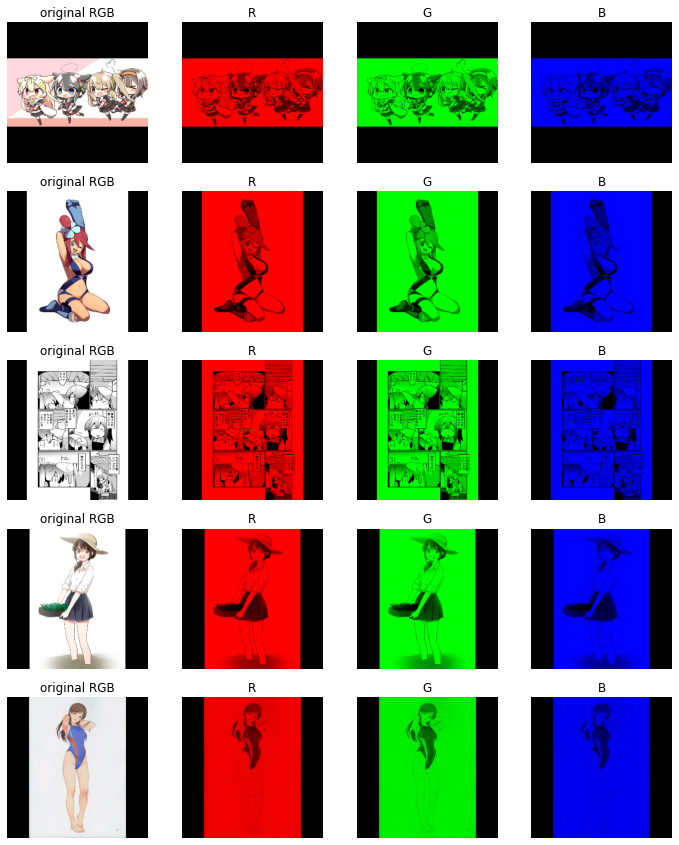

In [0]:
N =  5    # On limite volontairement l'affichage à 5 images 
count = 1 #compteur pour la figure
fig = plt.figure(figsize=(12,3*N))
for rgb in X_rgb[:N]:
    
    # Affichage de l'image original
    ax = fig.add_subplot(N,4,count)
    ax.imshow(rgb/255.0); ax.axis("off") #Les coeff des images rgb étant intialement compris entre 0  et 255, on les 
    ax.set_title("original RGB")         #normalise pour qu'ils soient compris entre 0 et 1
    count += 1
    
    #Affichage du rouge/vert/bleu de chaque image
    for i, lab in enumerate(["R","G","B"]):
        crgb = np.zeros(rgb.shape)
        crgb[:,:,i] = rgb[:,:,0]
        ax = fig.add_subplot(N,4,count)
        ax.imshow(crgb/255.0); ax.axis("off")
        ax.set_title(lab)
        count += 1
    
plt.show()

Maintenant qu'on s'est suffisament amusé, on va convertir les images du format RGB au format LAB (L pour *lightness*; A et B pour le spectre des couleurs du vert-rouge et du bleu jaune). Ce format fusionne les précédemment trois couches de couleurs en seulement deux couches. Pour cela on va utiliser la fonction *rgb2lab* du module *color*

L'avantage du format LAB est qu'on peut utiliser l'image en noir et blanc comme *input*, et qu'on travaille maintenant seulement sur deux couches au lieu de trois.

En format LAB, la première compostante est comprise entre -100 et 100, et les deux dernières composantes sont comprises entre -128 et 128.

In [0]:
X_lab = color.rgb2lab(X_bis)

X_lab = np.array(X_lab)


On va "standardiser" images de sorte que les compostantes soient comprises entre -1 et 1. Cela permet d'accélerer légèrement la vitesse de calcul et d'avoir plus de précision.

In [0]:
X = np.zeros(np.shape(X_lab))
X[:,:,:,0]=X_lab[:,:,:,0]/100   #grayscale
X[:,:,:,1:] = X_lab[:,:,:,1:]/128  #couleurs


### II-2/ **Réseau de neurones et apprentissage**

Il est l'heure de séparer nos données en données d'apprentissage Xtrain et en données de test Xtest selon un rapport 20-80.

On utilise la fonction reshape pour que Xtrain soit de la forme (Nsample, 256,256, 1) plutôt que (Nsample, 256, 256) (pour des raisons d'homogénéité avec la forme de Y)

Nos données d'entrées sont les X (qui correspondent aux images en noir et blanc) et nos données de sorties sont les Y (qui correspondent au deux couches de couleurs du format LAB.

In [0]:
test_size = 0.2

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X[:,:,:,0].reshape(X[:,:,:,0].shape+(1,)), X[:,:,:,1:], test_size=0.2, random_state=0)


(40, 256, 256, 1) (10, 256, 256, 1) (40, 256, 256, 2) (10, 256, 256, 2)


On vérifie que nos *inputs* et *outputs* ont la bonne forme, sans quoi notre algorithme rencontrerait un problème.

In [0]:
if __name__ == '__main__':
    unittest.main()

(40, 256, 256, 2)
(40, 256, 256, 1, 1)


On créer le réseau de neuronne. Il est composé de 15 couches dont 13 couches de convolution 2D avec un nombre de filtres allant de 64 à 512 par couches.

In [0]:
model = Sequential()
model.add(InputLayer(input_shape=(256, 256, 1)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))

Et on configure son processus d'apprentissage avec la fonction *.compile*. On choisit l'erreur quadratique moyenne *MSE* pour la fonction de perte et rmsprop pour l'optimiseur

In [0]:
model.compile(optimizer='rmsprop', loss='mse')

On passe à l'apprentissage de notre modèle. 
On opte pour un batch de taille 50, et un nombre d'epochs précisé dans le code.

In [0]:
batch_size = 50 # = nombre d'image qui entrent dans le réseau de neuronnes par étapes
model.fit(Xtrain, Ytrain, epochs=3, batch_size = batch_size)

Epoch 1/3
40/40 [==============================] - 5s 128ms/step - loss: 0.0081
Epoch 2/3
40/40 [==============================] - 5s 113ms/step - loss: 0.9523
Epoch 3/3
40/40 [==============================] - 4s 112ms/step - loss: 0.0080


In [0]:
print(model.evaluate(Xtest,Ytest, batch_size=batch_size))

10/10 [==============================] - 0s 23ms/step
0.004188942722976208


In [0]:
print(model.evaluate(Xtrain,Ytrain, batch_size=batch_size))

40/40 [==============================] - 1s 18ms/step
0.0077925920486450195


Le plus dur est passé. Générons les résultats désormais !

In [0]:
#On récupère les images à coloriser dans notre dataset test
X_pred = []
for filename in os.listdir('/content/drive/Shared drives/Walid & Waël/Test/'):
        X_pred.append(img_to_array(load_img('/content/drive/Shared drives/Walid & Waël/Test/'+filename, target_size=(256,256))))
X_pred = np.array(X_pred)
X_pred = rgb2lab(1.0/255*X_pred)[:,:,:,0]
X_pred = color_me.reshape(X_pred.shape+(1,))

# On teste le modèle
output = model.predict(X_pred)
output = output * 128

# On enregistre les sorties colorisées
for i in range(len(output)):
        cur = np.zeros((256, 256, 3))
        cur[:,:,0] = color_me[i][:,:,0]
        cur[:,:,1:] = output[i]
        plt.imsave("/content/drive/Shared drives/Walid & Waël/image_reseau_1"+str(i)+".png", lab2rgb(cur))

Et visualisons quelques images pour voir le résultat. Ces images colorisées ont été générées en entraînant notre algorithme sur un dataset de 5000 images, pendant une durée de 3h environ.

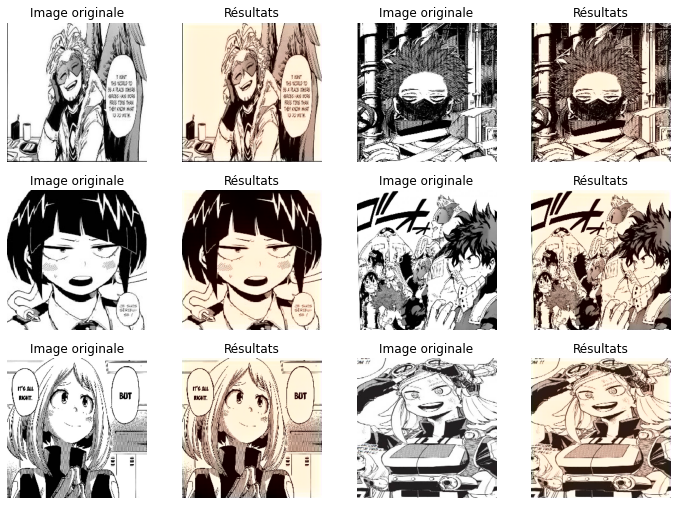

In [0]:
N =  6    # On limite volontairement l'affichage à 6 images 
count = 1 #compteur pour la figure

fig = plt.figure(figsize=(12,3*N))
for i in range(N):
    pred=img_to_array(load_img('/content/drive/Shared drives/Walid & Waël/Test/Test{}.jpg'.format(i+1), target_size=(256,256)))
    out=img_to_array(load_img('/content/drive/Shared drives/Walid & Waël/image_reseau_{}.png'.format(10+i))) 
    # Affichage de l'image original
    ax = fig.add_subplot(N,4,count)
    ax.imshow(pred/255.0); ax.axis("off") #Les coeff des images rgb étant intialement compris entre 0  et 255, on les 
    ax.set_title("Image originale")         #normalise pour qu'ils soient compris entre 0 et 1
    count += 1
    
    
    ax = fig.add_subplot(N,4,count)
    ax.imshow(out/255.0); ax.axis("off")
    ax.set_title("Résultat")
    count += 1
    
plt.show()

### II-3/ Résultats et analyse

Comme vous pouvez le constater, l'algorithme n'a fait qu'appliquer un filtre marron sur les images testées, sans pré-établir de couleurs adéquates ou de zones paritculières à utiliser. C'est loin d'être un résultat satisfaisant, mais c'est tout aussi loin d'être un résultat rare. Comme suggéré par [cet article](http://kvfrans.com/coloring-and-shading-line-art-automatically-through-conditional-gans/), nous allons passer d'une fonction de perte en MSE à une fonction de perte adversariable, sur des réseaux de type GAN (Réseaux antagonistes génératifs).

## III - 2$^{nd}$ Réseau de Neurones ► GAN

On va ici se baser sur un réseau GAN, largement inspiré de [celui-ci](https://github.com/pdrabinski/GAN_Colorizer).

### III-1/ Adaptation des données au réseau de neurones

In [0]:
import numpy as np
import pickle
from PIL import Image
from skimage import color, io
import matplotlib.pyplot as plt
from glob import glob

def un_scale(image):
    """
    Unscale L spectrum. Only used to doublecheck conversion from RGB to L.
    """
    image = np.squeeze(image)
    image = image * 100
    return image

def rgb_to_lab(image, l=False, ab=False):
    """
    Input: image in RGB format with full values for pixels. (0-255)
    Output: image in LAB format and with all values between -1 and 1.
    """
    image = image / 255
    l_channel = color.rgb2lab(image)[:,:,0]
    l_channel = l_channel / 50 - 1
    l_channel = l_channel[...,np.newaxis]

    ab_channels = color.rgb2lab(image)[:,:,1:]
    ab_channels = (ab_channels + 128) / 255 * 2 - 1
    if l:
        return l_channel
    else: return ab_channels

def lab_to_rgb(image):
    """
    Input: image in LAB format and with all values between -1 and 1.
    Output: image in RGB format with full values for pixels. (0-255)
    """
    new_img = np.zeros((256,256,3))
    for i in range(len(image)):
        for j in range(len(image[i])):
            p = image[i,j]
            new_img[i,j] = [(p[0] + 1) * 50,(p[1] +1) / 2 * 255 - 128,(p[2] +1) / 2 * 255 - 128]
    new_img = color.lab2rgb(new_img) * 255
    new_img = new_img.astype('uint8')
    return new_img


In [0]:
X_train = Ximg[:]
X_train=np.array([np.asarray(i) for i in X_train])

len(X_train)

10000

On mélange les données, et les sépare en données d'entraînement/donnée de test selon un ration 80/20.

In [0]:
np.random.shuffle(X_train)
X_test = X_train[:2500]      #20% du nombre de données.
X_train = X_train[2500:]     #idem
print('Train/Test Split Done...')
print(len(X_test), 'train images')
print(len(X_train), 'test images')

X_train_L = np.array([rgb_to_lab(image, l=True) for image in X_train])
print('X_train L layer done...')
X_train_AB = np.array([rgb_to_lab(image, ab=True) for image in X_train])
print('X_train a*b* layers done...')
X_train = (X_train_L, X_train_AB)
with open('/content/drive/Shared drives/Walid & Waël/Pickle/X_train.p','wb') as f:
    pickle.dump(X_train,f)   #On stock les données pour ne pas les écraser
print('X_train done...')

X_test_L = np.array([rgb_to_lab(image,l=True) for image in X_test])
print('X_test L layer done...')
X_test_AB = np.array([rgb_to_lab(image, ab=True) for image in X_test])
print('X_test a*b* layers done...')
X_test = (X_test_L, X_test_AB)
with open('/content/drive/Shared drives/Walid & Waël/Pickle/X_test.p','wb') as f:
    pickle.dump(X_test,f)   #On stock les données pour ne pas les écraser
print('X_test done...')

Train/Test Split Done...
2500 train images
7500 test images
X_train L layer done...
X_train a*b* layers done...


OverflowError: ignored

### III-2/ Réseau de neurones et apprentissage

In [0]:
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Activation, BatchNormalization, UpSampling2D, Dropout, Flatten, Dense, Input, LeakyReLU, Conv2DTranspose,AveragePooling2D, Concatenate
from keras.optimizers import Adam
from keras.models import Sequential
from tensorflow.compat.v1 import set_random_seed
import numpy as np
import matplotlib.pyplot as plt
import pickle
import keras.backend as K

np.random.seed(1)
set_random_seed(1)

def load_images(filepath):
    with open(filepath, 'rb') as f:
        return pickle.load(f)

class GAN():
    def __init__(self):
        """
        Initialize the GAN. Includes compiling the generator and the discriminator separately and then together as the GAN.
        """
        self.g_input_shape = (256,256,1)
        self.d_input_shape = (256,256,2)

        self.generator = self.build_generator()
        opt = Adam(lr=.001)
        self.generator.compile(loss='binary_crossentropy', optimizer=opt)
        print('Generator Summary...')
        print(self.generator.summary())

        self.discriminator = self.build_discriminator()
        opt = Adam(lr=.0001)
        self.discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        print('Discriminator Summary...')
        print(self.discriminator.summary())

        gan_input = Input(shape=self.g_input_shape)
        img_color = self.generator(gan_input)
        self.discriminator.trainable = False
        real_or_fake = self.discriminator(img_color)
        self.gan = Model(gan_input,real_or_fake)
        opt = Adam(lr=.001)
        self.gan.compile(loss='binary_crossentropy', optimizer=opt)
        print('\n')
        print('GAN summary...')
        print(self.gan.summary())

    def build_generator(self):
        """
        Returns generator as Keras model.
        """
        g_input = Input(shape=self.g_input_shape)
        #128 x 128
        conv1 = Conv2D(64, (3, 3), padding='same', strides=2)(g_input)
        conv1 = BatchNormalization()(conv1)
        conv1 = Activation('relu')(conv1)

        conv2 = Conv2D(128, (3, 3), padding='same', strides=1)(conv1)
        conv2 = BatchNormalization()(conv2)
        conv2 = Activation('relu')(conv2)

        #64 x 64
        conv3 = Conv2D(128, (3, 3), padding='same', strides=2)(conv2)
        conv3 = BatchNormalization()(conv3)
        conv3 = Activation('relu')(conv3)

        conv4 = Conv2D(256, (3, 3), padding='same', strides=1)(conv3)
        conv4 = BatchNormalization()(conv4)
        conv4 = Activation('relu')(conv4)

        #32 x 32
        conv5 = Conv2D(512, (3, 3), padding='same', strides=2)(conv4)
        conv5 = BatchNormalization()(conv5)
        conv5 = Activation('relu')(conv5)

        # conv6 = Conv2D(512, (3, 3), padding='same', strides=1)(conv5)
        # conv6 = BatchNormalization()(conv6)
        # conv6 = Activation('relu')(conv6)

        #64 x 64
        conv7 = UpSampling2D(size=(2, 2))(conv5)
        conv7 = Conv2D(256, (3, 3), padding='same')(conv7)
        conv7 = BatchNormalization()(conv7)
        conv7 = Activation('relu')(conv7)
        conv7 = Concatenate(axis=-1)([conv7,conv4])

        conv8 = Conv2D(256, (3, 3), padding='same')(conv7)
        conv8 = BatchNormalization()(conv8)
        conv8 = Activation('relu')(conv8)

        #128 x 128
        up2 = UpSampling2D(size=(2, 2))(conv8)
        conv9 = Conv2D(128, (3,3), padding='same')(up2)
        conv9 = BatchNormalization()(conv9)
        conv9 = Activation('relu')(conv9)
        conv9 = Concatenate(axis=-1)([conv9,conv2])

        conv10 = Conv2D(128, (3, 3), padding='same')(conv9)
        conv10 = BatchNormalization()(conv10)
        conv10 = Activation('relu')(conv10)

        up3 = UpSampling2D(size=(2, 2))(conv10)
        conv11 = Conv2D(64, (3,3), padding='same')(up3)
        conv11 = BatchNormalization()(conv11)
        conv11 = Activation('relu')(conv11)

        conv12 = Conv2D(2, (3, 3), padding='same')(conv11)
        conv12 = Activation('tanh')(conv12)

        model = Model(inputs=g_input,outputs=conv12)
        return model

    def build_discriminator(self):
        """
        Returns discriminator as Keras model.
        """
        model = Sequential()
        model.add(Conv2D(32, (3, 3), padding='same', input_shape=self.d_input_shape, strides=2))
        model.add(LeakyReLU(.2))
        # model.add(Dropout(.25))

        model.add(AveragePooling2D(pool_size=(2, 2)))
        model.add(Conv2D(64, (3, 3), padding='same',strides=1))
        model.add(BatchNormalization())
        model.add(LeakyReLU(.2))
        model.add(Dropout(.25))

        model.add(AveragePooling2D(pool_size=(2, 2)))
        model.add(Conv2D(128, (3, 3), padding='same',strides=1))
        model.add(BatchNormalization())
        model.add(LeakyReLU(.2))
        model.add(Dropout(.25))

        # model.add(AveragePooling2D(pool_size=(2, 2)))
        model.add(Conv2D(256, (3, 3), padding='same',strides=2))
        model.add(BatchNormalization())
        model.add(LeakyReLU(.2))
        model.add(Dropout(.5))

        # model.add(Conv2D(512, (3, 3), padding='same',strides=2))
        # model.add(BatchNormalization())
        # model.add(LeakyReLU(.2))
        # model.add(Dropout(.25))

        model.add(Flatten())
        # model.add(Dense(512))
        # model.add(Dropout(.5))
        model.add(Dense(1))
        model.add(Activation('sigmoid'))

        return model

    def train_discriminator(self, X_train_L, X_train_AB, X_test_L, X_test_AB):
        """
        Function to train the discriminator. Called when discriminator accuracy falls below and a specified threshold.
        """
        generated_images = self.generator.predict(X_train_L)
        X_train = np.concatenate((X_train_AB, generated_images))
        n = len(X_train_L)
        y_train = np.array([[1]] * n + [[0]] * n)
        rand_arr = np.arange(len(X_train))
        np.random.shuffle(rand_arr)
        X_train = X_train[rand_arr]
        y_train = y_train[rand_arr]

        test_generated_images = self.generator.predict(X_test_L)
        X_test = np.concatenate((X_test_AB, test_generated_images))
        n = len(X_test_L)
        y_test = np.array([[1]] * n + [[0]] * n)
        rand_arr = np.arange(len(X_test))
        np.random.shuffle(rand_arr)
        X_test = X_test[rand_arr]
        y_test = y_test[rand_arr]

        self.discriminator.fit(x=X_train, y=y_train, epochs=1)
        metrics = self.discriminator.evaluate(x=X_test, y=y_test)
        print('\n accuracy:',metrics[1])
        if metrics[1] < .90:
            self.train_discriminator(X_train_L, X_train_AB, X_test_L, X_test_AB)

    def train(self, X_train_L, X_train_AB, X_test_L, X_test_AB, epochs):
        """
        Training loop for GAN. First the discriminator is fit with real and fake images. Next the Generator is fit. This is possible because the weights in the Discriminator are fixed and not affected by back propagation.
        Inputs: X_train L channel, X_train AB channels, X_test L channel, X_test AB channels, number of epochs.
        Outputs: Models are saved and loss/acc plots saved.
        """

        # self.train_discriminator(X_train_L, X_train_AB, X_test_L, X_test_AB)
        g_losses = []
        d_losses = []
        d_acc = []
        X_train = X_train_L
        n = len(X_train)
        y_train_fake = np.zeros([n,1])
        y_train_real = np.ones([n,1])
        for e in range(epochs):
            #generate images
            np.random.shuffle(X_train)
            generated_images = self.generator.predict(X_train, verbose=1)
            np.random.shuffle(X_train_AB)

            #Train Discriminator
            d_loss  = self.discriminator.fit(x=X_train_AB, y=y_train_real,  batch_size=16, epochs=1)
            if e % 3 == 2:
                noise = np.random.rand(n,256,256,2) * 2 -1
                d_loss = self.discriminator.fit(x=noise, y=y_train_fake, batch_size=16, epochs=1)
            d_loss = self.discriminator.fit(x=generated_images, y=y_train_fake, batch_size=16, epochs=1)
            d_losses.append(d_loss.history['loss'][-1])
            d_acc.append(d_loss.history["accuracy"][-1])
            print('d_loss:', d_loss.history['loss'][-1])
            # print("Discriminator Accuracy: ", disc_acc)

            #train GAN on grayscaled images , set output class to colorized
            g_loss = self.gan.fit(x=X_train, y=y_train_real, batch_size=16, epochs=1)

            #Record Losses/Acc
            g_losses.append(g_loss.history['loss'][-1])
            print('Generator Loss: ', g_loss.history['loss'][-1])
            disc_acc = d_loss.history["accuracy"][-1]

            # Retrain Discriminator if accuracy drops below .8
            if disc_acc < .8 and e < (epochs / 2):
                self.train_discriminator(X_train_L, X_train_AB, X_test_L, X_test_AB)
            if e % 5 == 4:
                print(e + 1,"batches done")

        self.plot_losses(g_losses,'Generative Loss', epochs)
        self.plot_losses(d_acc, 'Discriminative Accuracy',epochs)
        self.generator.save('/content/drive/Shared drives/Walid & Waël/Models/gen_model_full_batch_' + str(epochs)+'.h5')
        self.discriminator.save('/content/drive/Shared drives/Walid & Waël/Models/disc_model_full_batch_' + str(epochs)+'.h5')

    def plot_losses(self, metric, label, epochs):
        """
        Plot the loss/acc of the generator/discriminator.
        Inputs: metric, label of graph, number of epochs (for file name)
        """
        plt.plot(metric, label=label)
        plt.title('GAN Accuracy and Loss Over ' + str(epochs) + ' Epochs')
        plt.savefig('/content/drive/Shared drives/Walid & Waël/Plots/plot_' + str(epochs) + '_epochs.png')
        # plt.close()



On crée et entraîne le modèle.

Generator Summary...
Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_91 (Conv2D)              (None, 128, 128, 64) 640         input_13[0][0]                   
__________________________________________________________________________________________________
batch_normalization_79 (BatchNo (None, 128, 128, 64) 256         conv2d_91[0][0]                  
__________________________________________________________________________________________________
activation_73 (Activation)      (None, 128, 128, 64) 0           batch_normalization_79[0][0]     
______________________________________________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1/1
35/35 [==============================] - 2s 63ms/step - loss: 0.7799 - accuracy: 0.6000
Epoch 1/1
35/35 [==============================] - 2s 48ms/step - loss: 2.2848 - accuracy: 0.0286
d_loss: 2.2847712925502233
Epoch 1/1
35/35 [==============================] - 134s 4s/step - loss: 0.1942
Generator Loss:  0.19420393577643802
Epoch 1/1
30/30 [==============================] - 1s 17ms/step

 accuracy: 0.8666666746139526
Epoch 1/1
30/30 [==============================] - 0s 15ms/step

 accuracy: 0.800000011920929
Epoch 1/1
30/30 [==============================] - 0s 15ms/step

 accuracy: 0.7333333492279053
Epoch 1/1
30/30 [==============================] - 0s 15ms/step

 accuracy: 0.7333333492279053
Epoch 1/1
30/30 [==============================] - 0s 15ms/step

 accuracy: 0.7666666507720947
Epoch 1/1
30/30 [==============================] - 0s 15ms/step

 accuracy: 0.8333333134651184
Epoch 1/1
30/30 [==============================] - 0s 15ms/step

 accuracy: 0.86666667461395

FileNotFoundError: ignored

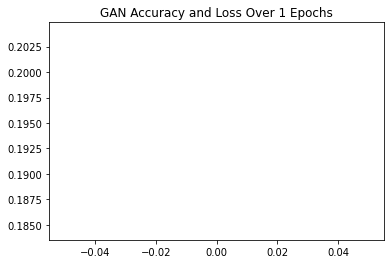

In [0]:
epochs = 30   # Le nombre d'epochs signifie le nombre de fois que l'algorithme va repasser sur nos données.

gan = GAN()
gan.train(X_train_L, X_train_AB, X_test_L, X_test_AB, epochs)

Et on génère les résultats.

In [0]:
###sur la base à colorier 

color_me = []
for filename in os.listdir('/content/drive/Shared drives/Walid & Waël/Test/'):
        color_me.append(img_to_array(load_img('/content/drive/Shared drives/Walid & Waël/Test/'+filename, target_size=(256,256))))
color_me = np.array(color_me)
color_me = rgb2lab(1.0/255*color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape+(1,))

# Test model
output = gan.generator.predict(color_me)
output = output * 128

# Output colorizations
for i in range(len(output)):
        cur = np.zeros((256, 256, 3))
        cur[:,:,0] = color_me[i][:,:,0]
        cur[:,:,1:] = output[i]
        plt.imsave("/content/drive/Shared drives/Walid & Waël/Results/ganimage_"+str(i)+".png", lab2rgb(cur))

NameError: ignored

### III-3/ Résultats et analyse

Affichons les résultats pour 1000 données, 3 epochs : 

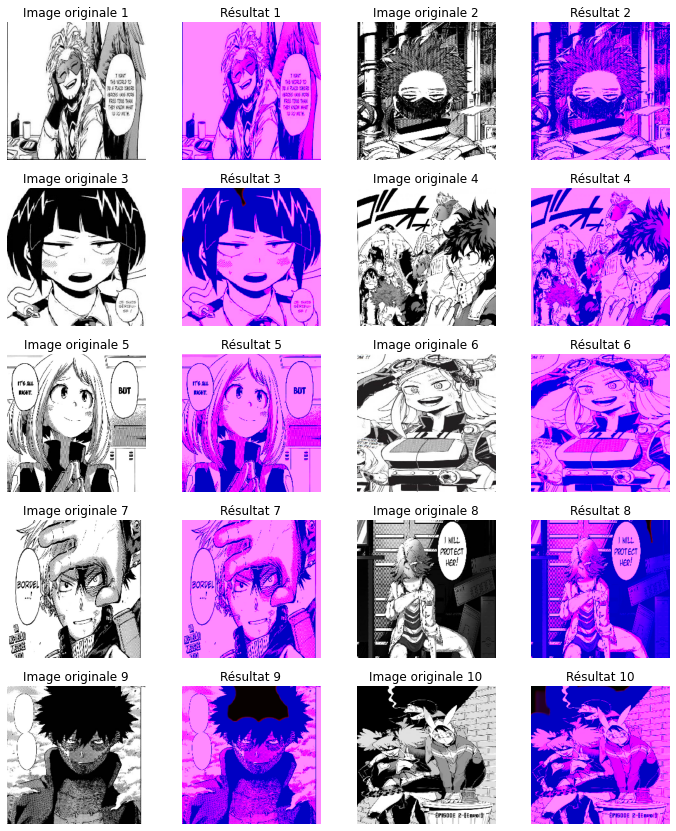

In [0]:
N =  10   
count = 1 #compteur pour la figure

fig = plt.figure(figsize=(12,3*N))
for i in range(N):
    pred=img_to_array(load_img('/content/drive/Shared drives/Walid & Waël/Test/Test{}.jpg'.format(i+1), target_size=(256,256)))
    out=img_to_array(load_img('/content/drive/Shared drives/Walid & Waël/Results/ganimage_{}.png'.format(i))) 
    # Affichage de l'image original
    ax = fig.add_subplot(N,4,count)
    ax.imshow(pred/255.0); ax.axis("off") #Les coeff des images rgb étant intialement compris entre 0  et 255, on les 
    ax.set_title("Image originale {}".format(i+1))         #normalise pour qu'ils soient compris entre 0 et 1
    count += 1
    
    
    ax = fig.add_subplot(N,4,count)
    ax.imshow(out/255.0); ax.axis("off")
    ax.set_title("Résultat {}".format(i+1))
    count += 1
    
plt.show()

Le résultat est là encore l'application d'un filtre de couleur, mais comme on peut le voir sur les images 9, 8 et 10, cette fois l'algorithme différencies plusieurs zones et, par exemple, décide de ne pas colorer les cheveux. 

Désormais, appliquons l'algorithme pour 3000 images et 30 epochs :

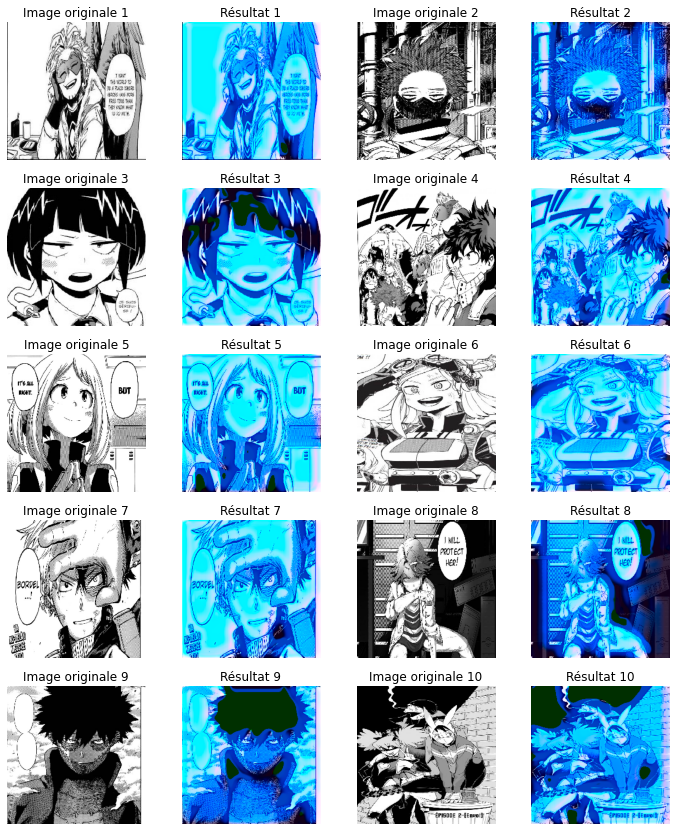

In [0]:
N =  10   
count = 1 #compteur pour la figure

fig = plt.figure(figsize=(12,3*N))
for i in range(N):
    pred=img_to_array(load_img('/content/drive/Shared drives/Walid & Waël/Test/Test{}.jpg'.format(i+1), target_size=(256,256)))
    out=img_to_array(load_img('/content/drive/Shared drives/Walid & Waël/Results/3Kim_30epoch_{}.png'.format(i))) 
    # Affichage de l'image original
    ax = fig.add_subplot(N,4,count)
    ax.imshow(pred/255.0); ax.axis("off") #Les coeff des images rgb étant intialement compris entre 0  et 255, on les 
    ax.set_title("Image originale {}".format(i+1))         #normalise pour qu'ils soient compris entre 0 et 1
    count += 1
    
    
    ax = fig.add_subplot(N,4,count)
    ax.imshow(out/255.0); ax.axis("off")
    ax.set_title("Résultat {}".format(i+1))
    count += 1
    
plt.show()

Là le résultat est bien meilleur. L'image n'est pas colorée de façon uniforme mais par zone. L'image la plus intéressante est à notre sens la n°4 : 

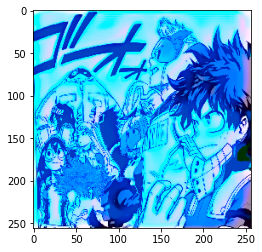

In [16]:
plt.imshow(1/255*img_to_array(load_img('/content/drive/Shared drives/Walid & Waël/Results/3Kim_30epoch_{}.png'.format(3))))

On voit bien que la couleur n'est pas appliquée aléatoirement, mais semble suivre quelques contours. Ce n'est pas encore exploitable pour de la vraie colorisation, mais c'est sans aucun doute le signe d'un net progrès depuis les images marrons.

Voyons aussi l'évolution de l'erreur en fonction du nombre d'epochs : 

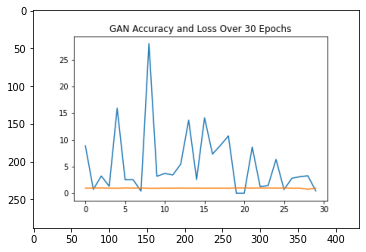

In [20]:
plt.imshow(1/255*img_to_array(load_img('/content/drive/Shared drives/Walid & Waël/Plots/plot_30_epochs.png')))

Celle-ci diminue au fil des epochs, signe manifeste d'une qualité de la colorisation qui s'améliore dans le même temps - ce que nous pouvons constater via les images ci-dessus.

*Note :* Les changements de filtres colorés appliqués aux images nous sont un mystère.

## IV - Résultats et Conclusions

En conclusion, pour ce qui est de la colorisation d'images de mangas, les réseaux utilisant des méthodes adversarielles se sont révélés bien plus efficaces que ceux utilisant une erreur en MSE. Nous avons réussi à améliorer des résultats initiaux bien peu convaincants, et avons la direction tout indiquée pour une possible amélioration des résultats : les GAN. 

Nous aimerions néanmoins souligner les difficultés que nous avons rencontré, notamment sur le manque de compatibilité entre Tensorflow 1.x et Tensorflow 2, certaines bibliothèques (comme tf.compat) ayant été carrément supprimées et nous obligeant à une certaine flexibilité. De même, le sujet de colorisation de mangas via le Machine Learning n'est pas encore fourni d'une documentation gigantesque ; les quelques articles que nous avons trouvés étaient cependant de bonne qualité et nous ont beaucoup aidés. 

Au début du semestre, nous ne connaissions presque rien au Machine Learning ; ce projet nous a permis de mettre un premier pas dans ce monde et d'en apprécier les possibilités, mais aussi les limites. En mot de la fin, malgré les obstacles rencontrés, nous sommes très satisfaits d'avoir choisi ce sujet que, peut-être, nous approfondirons dans un nouveau projet l'année prochaine.  

  


BOUKHOBZA Waël, 
CHRIMNI Walid.